# Diffusion for 256 x 256

In [14]:
import jupyter_black

import sys, os, shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [13]:
# Custom modules
from dataset import create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import show_grid_samples, train, count_fid_metric, logging

In [43]:
# Dirs
sample_dir = "/usr/src/samples_substrate"
substrate_dir = "/usr/src/substrates"
part_substrate_dir = "/usr/src/part_substrates"

image_size = 256

In [ ]:
# Cut part substrates
get_part_substrates_from_all(
    substrate_dir, part_substrate_dir, part_size=(image_size, image_size)
)

In [9]:
# Create dataset of the substrates
substrate_dataset = create_substrate_dataset(part_substrate_dir)

# Settings
channels = 1
batch_size = 10

# Create dataloader for training
train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# Initialization of the denoising model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# Initialization of the diffusion

timesteps = 300
diffusion = Diffusion(timesteps)

In [19]:
# Training (about 11 minutes on NVIDIA)

epochs = 5
log_path = "logging_substrates"
log_interval = len(train_loader) // 5

loss_progress = train(
    model, diffusion, timesteps, train_loader, epochs, optimizer, device, log_path, log_interval
)

----- Epoch 1 -----
Loss: 0.41550540924072266


Loss: 0.0074116820469498634
Loss: 0.00914283748716116
Loss: 0.009146058931946754
Loss: 0.03769039735198021


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.017611188814044
Loss: 0.01966789923608303
Loss: 0.0213748998939991
Loss: 0.028297370299696922
Loss: 0.008948350325226784


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.0030595283024013042
Loss: 0.0055517698638141155
Loss: 0.001227065920829773
Loss: 0.0022136501502245665
Loss: 0.0007142738322727382


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.004108085762709379
Loss: 0.005925736855715513
Loss: 0.0008549437043257058
Loss: 0.003825650317594409
Loss: 0.016254350543022156


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.001612854772247374
Loss: 0.001221960294060409
Loss: 0.011845524422824383
Loss: 0.0012338671367615461
Loss: 0.0032293430995196104


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

In [20]:
# Saving model

torch.save(model, f"substrate_denoise_model_{epochs}_epochs.pt")

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

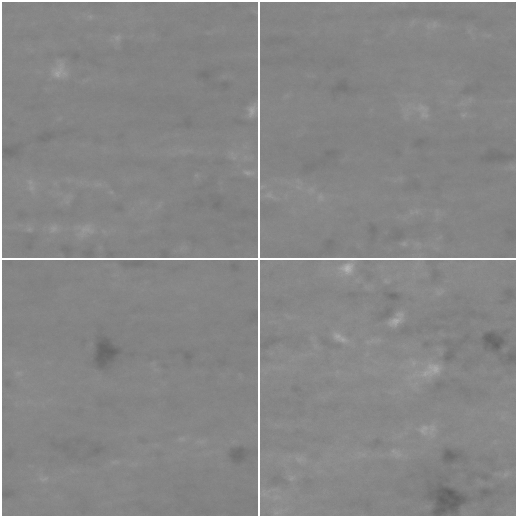

In [24]:
# Create grid of generated samples and show it

n_samples = 4
samples = show_grid_samples(n_samples, diffusion, model, image_size, channels)

In [44]:
# Generate many new separate samples and save them

from utils_diffusion import generate_and_save_samples

generate_and_save_samples(sample_dir, 10, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]